## Health Insurance Analysis in U.S. (2010 to 2016)

Health insurance coverage data compiled from the US Department of Health and Human Services and US Census Bureau.

*Source:* https://www.kaggle.com/hhs/health-insurance


In [120]:
import pandas as pd
import numpy as np
import seaborn as sns

health_insurance = pd.read_csv("../metis_IDS_project/data/health-insurance.csv")

In [121]:
health_insurance.dtypes

State                                            object
Uninsured Rate (2010)                            object
Uninsured Rate (2015)                            object
Uninsured Rate Change (2010-2015)                object
Health Insurance Coverage Change (2010-2015)      int64
Employer Health Insurance Coverage (2015)         int64
Marketplace Health Insurance Coverage (2016)      int64
Marketplace Tax Credits (2016)                    int64
Average Monthly Tax Credit (2016)                object
State Medicaid Expansion (2016)                  object
Medicaid Enrollment (2013)                      float64
Medicaid Enrollment (2016)                        int64
Medicaid Enrollment Change (2013-2016)          float64
Medicare Enrollment (2016)                        int64
dtype: object

In [122]:
health_insurance.head()

,State,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015),Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Average Monthly Tax Credit (2016),State Medicaid Expansion (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
0,Alabama,14.6%,10.1%,-4.5%,215000,2545000,165534,152206,$310,False,799176.0,910775,111599.0,989855
1,Alaska,19.9%,14.9%,-5%,36000,390000,17995,16205,$750,True,122334.0,166625,44291.0,88966
2,Arizona,16.9%,10.8%,-6.1%,410000,3288000,179445,124346,$230,True,1201770.0,1716198,514428.0,1175624
3,Arkansas,17.5%,9.5%,-8%,234000,1365000,63357,56843,$306,True,556851.0,920194,363343.0,606146
4,California,18.5%,8.6%,-9.9%,3826000,19552000,1415428,1239893,$309,True,7755381.0,11843081,4087700.0,5829777


In [88]:
health_insurance.tail()

,State,Uninsured Rate (2010),Uninsured Rate (2015),Uninsured Rate Change (2010-2015),Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Average Monthly Tax Credit (2016),State Medicaid Expansion (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
47,Washington,14.2%,6.6%,-7.6%,537000,3986000,158245,110476,$238,True,1117576.0,1788536,670960.0,1238649
48,West Virginia,14.6%,6%,-8.6%,156000,976000,33235,29163,$388,True,354544.0,575645,221101.0,423500
49,Wisconsin,9.4%,5.7%,-3.7%,211000,3521000,224208,190542,$332,False,985531.0,1046897,61366.0,1084854
50,Wyoming,14.9%,11.5%,-3.4%,20000,335000,22076,20313,$459,False,67518.0,63583,-3935.0,99128
51,United States,15.5%,9.4%,6.1%,19304000,172292000,11081330,9389609,$291,NaN,56392477.0,73532931,16106157.0,57149984


In [89]:
health_insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 14 columns):
State                                           52 non-null object
Uninsured Rate (2010)                           52 non-null object
Uninsured Rate (2015)                           52 non-null object
Uninsured Rate Change (2010-2015)               52 non-null object
Health Insurance Coverage Change (2010-2015)    52 non-null int64
Employer Health Insurance Coverage (2015)       52 non-null int64
Marketplace Health Insurance Coverage (2016)    52 non-null int64
Marketplace Tax Credits (2016)                  52 non-null int64
Average Monthly Tax Credit (2016)               52 non-null object
State Medicaid Expansion (2016)                 51 non-null object
Medicaid Enrollment (2013)                      50 non-null float64
Medicaid Enrollment (2016)                      52 non-null int64
Medicaid Enrollment Change (2013-2016)          50 non-null float64
Medicare Enrollment (2016)   

In [11]:
health_insurance.corr()

,Health Insurance Coverage Change (2010-2015),Employer Health Insurance Coverage (2015),Marketplace Health Insurance Coverage (2016),Marketplace Tax Credits (2016),Medicaid Enrollment (2013),Medicaid Enrollment (2016),Medicaid Enrollment Change (2013-2016),Medicare Enrollment (2016)
Health Insurance Coverage Change (2010-2015),1.000000,0.994852,0.994007,0.992927,0.995612,0.997142,0.993211,0.994144
Employer Health Insurance Coverage (2015),0.994852,1.000000,0.993882,0.991851,0.998722,0.998084,0.985844,0.999484
Marketplace Health Insurance Coverage (2016),0.994007,0.993882,1.000000,0.999825,0.991694,0.991108,0.979194,0.995248
Marketplace Tax Credits (2016),0.992927,0.991851,0.999825,1.000000,0.989580,0.989097,0.977569,0.993561
Medicaid Enrollment (2013),0.995612,0.998722,0.991694,0.989580,1.000000,0.999405,0.987719,0.998103
Medicaid Enrollment (2016),0.997142,0.998084,0.991108,0.989097,0.999405,1.000000,0.992505,0.997334
Medicaid Enrollment Change (2013-2016),0.993211,0.985844,0.979194,0.977569,0.987719,0.992505,1.000000,0.984525
Medicare Enrollment (2016),0.994144,0.999484,0.995248,0.993561,0.998103,0.997334,0.984525,1.000000


In [67]:
health_insurance.rename(columns={
    "UninsRate2010": "UIRate2010", 
    "UninsRate2015": "UIRate2015", 
    "RateChange" : "RateChange2010-15",
    "Health Insurance Coverage Change (2010-2015)":"HICChange2010-15", 
    "EmployerHIC": "EmployerHIC2015", 
    "Marketplace Health Insurance Coverage (2016)":"MarketplaceHIC2016", 
    "Marketplace Tax Credits (2016)":"MarketplaceTaxCredit2016",
    "Average Monthly Tax Credit (2016)":"AvgMonthlyTaxCredit2016",
    "State Medicaid Expansion (2016)":"StateMedicaidExpansion2016",
    "Medicaid Enrollment (2013)":"MedicaidEnrollment2013",
    "Medicaid Enrollment (2016)":"MedicaidEnrollment2016",
    "Medicaid Enrollment Change (2013-2016)":"MedicaidEnrollmentChange2013-16",
    "Medicare Enrollment (2016)":"MedicareEnrollment2016"

}, inplace=True)
health_insurance.head()


,State,UIRate2010,UIRate2015,RateChange2010-15,HICChange2010-15,EmployerHIC2015,MarketplaceHIC2016,MarketplaceTaxCredit2016,AvgMonthlyTaxCredit2016,StateMedicaidExpansion2016,MedicaidEnrollment2013,MedicaidEnrollment2016,MedicaidEnrollmentChange2013-16,MedicareEnrollment2016
0,Alabama,14.6%,10.1%,-4.5%,215000,2545000,165534,152206,$310,False,799176.0,910775,111599.0,989855
1,Alaska,19.9%,14.9%,-5%,36000,390000,17995,16205,$750,True,122334.0,166625,44291.0,88966
2,Arizona,16.9%,10.8%,-6.1%,410000,3288000,179445,124346,$230,True,1201770.0,1716198,514428.0,1175624
3,Arkansas,17.5%,9.5%,-8%,234000,1365000,63357,56843,$306,True,556851.0,920194,363343.0,606146
4,California,18.5%,8.6%,-9.9%,3826000,19552000,1415428,1239893,$309,True,7755381.0,11843081,4087700.0,5829777


In [76]:
print("Correlation between uninsured rate in 2015 and employer health care coverage in 2015:\n", health_insurance.UIRate2015.corr(health_insurance.EmployerHIC2015, method="spearman") )

Correlation between uninsured rate in 2015 and employer health care coverage in 2015:
 0.2881663579384873


In [75]:
print("Correlation between employer health care coverage in 2015 and Medicaid enrollment in 2016:\n", health_insurance.EmployerHIC2015.corr(health_insurance.MedicaidEnrollment2016, method="spearman") )

Correlation between employer health care coverage in 2015 and Medicaid enrollment in 2016:
 0.9591052676513275


In [77]:
print("Correlation between employer health care coverage in 2015 and Medicare enrollment in 2016:\n", health_insurance.EmployerHIC2015.corr(health_insurance.MedicareEnrollment2016, method="spearman") )

Correlation between employer health care coverage in 2015 and Medicare enrollment in 2016:
 0.9873644668317254


In [82]:
print("Correlation between employer health care coverage in 2015 and Medicare enrollment change\n from 2013 to 2016:\n", health_insurance.EmployerHIC2015.corr(health_insurance["MedicaidEnrollmentChange2013-16"], method="spearman") )

Correlation between employer health care coverage in 2015 and Medicare enrollment change
 from 2013 to 2016:
 0.773829531812725


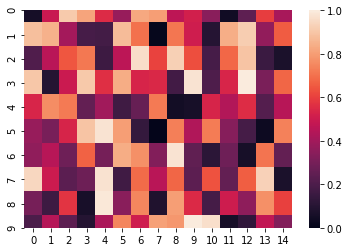

In [113]:
health_insurance = np.random.rand(10, 15)
ax = sns.heatmap(health_insurance, vmin=0, vmax=1)
